# LightGBM模型调优


In [1]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np

import lightgbm as lgbm
from lightgbm.sklearn import LGBMClassifier

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

## 读取数据

In [2]:
# 读取数据
train = pd.read_csv("FE_train.csv")

y_train = train['Disbursed'] 
X_train = train.drop(["ID", "Disbursed"], axis=1)

#保存特征名字以备后用（可视化）
feat_names = X_train.columns 

## LightGBM超参数调优

LightGBM的主要的超参包括：
1. 树的数目n_estimators 和 学习率 learning_rate
2. 树的最大深度max_depth 和 树的最大叶子节点数目num_leaves（LightGBM采用叶子优先的方式生成树，num_leaves很重要，设置成比 2^max_depth 小）
3. 叶子结点的最小样本数:min_data_in_leaf(min_data, min_child_samples)
4. 每棵树的列采样比例：feature_fraction/colsample_bytree
5. 每棵树的行采样比例：bagging_fraction （需同时设置bagging_freq=1）/subsample
6. 正则化参数lambda_l1(reg_alpha), lambda_l2(reg_lambda)

7. 两个非模型复杂度参数，但会影响模型速度和精度。可根据特征取值范围和样本数目修改这两个参数
1）特征的最大bin数目max_bin：默认255；
2）用来建立直方图的样本数目subsample_for_bin：默认200000。

对n_estimators，用LightGBM内嵌的cv函数调优，因为同XGBoost一样，LightGBM学习的过程内嵌了cv，速度极快。
其他参数用GridSearchCV

In [3]:
MAX_ROUNDS = 10000

### 相同的交叉验证分组
样本数太多（87020），CV折数越多，cv性能越好。
可能是由于GBDT是很复杂的模型，其实数据越多越好（cv折数多，每次留出的样本少，参数模型训练的样本更多）

In [29]:
# prepare cross validation
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

### 1. n_estimators

In [30]:
#直接调用lightgbm内嵌的交叉验证(cv)，可对连续的n_estimators参数进行快速交叉验证
#而GridSearchCV只能对有限个参数进行交叉验证，且速度相对较慢
def get_n_estimators(params , X_train , y_train , early_stopping_rounds=10):
    lgbm_params = params.copy()
     
    lgbmtrain = lgbm.Dataset(X_train , y_train )
     
    #num_boost_round为弱分类器数目，下面的代码参数里因为已经设置了early_stopping_rounds
    #即性能未提升的次数超过过早停止设置的数值，则停止训练
    cv_result = lgbm.cv(lgbm_params , lgbmtrain , num_boost_round=MAX_ROUNDS , nfold=5,  metrics='auc' , early_stopping_rounds=early_stopping_rounds,seed=3 )
     
    print('best n_estimators:' , len(cv_result['auc-mean']))
    print('best cv score:' , cv_result['auc-mean'][-1])
     
    return len(cv_result['auc-mean'])

In [31]:
params = {'boosting_type': 'goss',
          'objective': 'binary',
          'is_unbalance':True,
          #'categorical_feature': names:'City', 'Employer_Name', 'Salary_Account','Device_Type','Filled_Form','Gender','Mobile_Verified','Source','Var1','Var2','Var4',
          'categorical_feature': [0,1,3,5,6,12,15,16,17,18,19,20],
          'n_jobs': 4,
          'learning_rate': 0.1,
          #'n_estimators':n_estimators_1,
          'num_leaves': 60,
          'max_depth': 6,
          'colsample_bytree': 0.7,
          'verbosity':5
         }

#categorical_feature = ['City', 'Employer_Name', 'Salary_Account','Device_Type','Filled_Form','Gender','Mobile_Verified','Source','Var1','Var2','Var4']
n_estimators_1 = get_n_estimators(params, X_train , y_train)

('best n_estimators:', 38)
('best cv score:', 0.8455091020436194)


### 2. num_leaves & max_depth=7
num_leaves建议70-80，搜索区间50-80,值越大模型越复杂，越容易过拟合
相应的扩大max_depth=7

In [32]:
params = {'boosting_type': 'goss',
          'objective': 'binary',
          'is_unbalance':True,
          'categorical_feature': [0,1,3,5,6,12,15,16,17,18,19,20],
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          #'num_leaves': 60,
          'max_depth': 6,
          'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

num_leaves_s = range(50,90,10) #50,60,70,80
tuned_parameters = dict( num_leaves = num_leaves_s)

grid_search = GridSearchCV(lg, n_jobs=4, param_grid=tuned_parameters, cv = kfold, scoring="roc_auc", verbose=5, refit = False)
grid_search.fit(X_train , y_train)
#grid_search.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] num_leaves=50 ...................................................
[CV] num_leaves=50 ...................................................
[CV] num_leaves=50 ...................................................
[CV] num_leaves=50 ...................................................
[CV] .............. num_leaves=50, score=0.833265759508, total=   0.8s
[CV] ............... num_leaves=50, score=0.86334968273, total=   0.9s
[CV] num_leaves=50 ...................................................
[CV] .............. num_leaves=50, score=0.843559092769, total=   0.8s
[CV] .............. num_leaves=50, score=0.832192191162, total=   0.9s
[CV] num_leaves=60 ...................................................
[CV] num_leaves=60 ...................................................
[CV] num_leaves=60 ...................................................
[CV] .............. num_leaves=50, score=0.846767309955, total=   0.9s
[CV] num_leaves=6

[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.9s


[CV] .............. num_leaves=70, score=0.834432287201, total=   1.1s
[CV] num_leaves=80 ...................................................
[CV] .............. num_leaves=70, score=0.848371475943, total=   0.9s
[CV] .............. num_leaves=70, score=0.836587624729, total=   1.0s
[CV] num_leaves=80 ...................................................
[CV] .............. num_leaves=70, score=0.846724953086, total=   0.9s
[CV] num_leaves=80 ...................................................
[CV] num_leaves=80 ...................................................
[CV] .............. num_leaves=80, score=0.859989481507, total=   1.0s
[CV] num_leaves=80 ...................................................
[CV] .............. num_leaves=80, score=0.836587624729, total=   0.9s
[CV] .............. num_leaves=80, score=0.848371475943, total=   0.9s
[CV] .............. num_leaves=80, score=0.834432287201, total=   1.0s


[Parallel(n_jobs=4)]: Done  18 out of  20 | elapsed:    6.5s remaining:    0.7s


[CV] .............. num_leaves=80, score=0.846724953086, total=   1.0s


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    6.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='goss',
        categorical_feature=[0, 1, 3, 5, 6, 12, 15, 16, 17, 18, 19, 20],
        colsample_bytree=0.7, is_unbalance=True, learning_rate=0.1,
        max_bin=255, max_depth=6, min_child_samples=10, min_child_weight=5,
        min_split_gain=0.0, n_estimators=38, n_jobs=4, num_leaves=31,
        objective='binary', random_state=0, reg_alpha=0.0, reg_lambda=0.0,
        silent=False, subsample=1.0, subsample_for_bin=50000,
        subsample_freq=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'num_leaves': [50, 60, 70, 80]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='roc_auc', verbose=5)

In [33]:
# examine the best model
print(grid_search.best_score_)
print(grid_search.best_params_)

0.84522115674
{'num_leaves': 70}


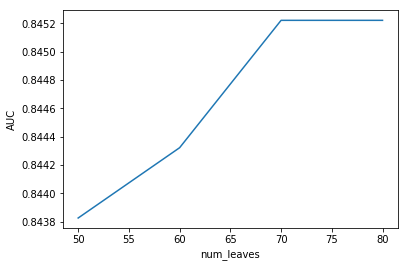

In [34]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

n_leafs = len(num_leaves_s)

x_axis = num_leaves_s
plt.plot(x_axis, test_means)
#plt.errorbar(x_axis, -test_means, yerr=test_stds,label = ' Test')
#plt.errorbar(x_axis, -train_means, yerr=train_stds,label = ' Train')
plt.xlabel( 'num_leaves' )
plt.ylabel( 'AUC' )
plt.show()

In [35]:
test_means

array([ 0.84382687,  0.84432275,  0.84522116,  0.84522116])

#### 性能抖动，取系统推荐值：70

### 3. min_child_samples
叶子节点的最小样本数目

叶子节点数目：70，共2类，平均每类35个叶子节点
每棵树的样本数目数目最少的类（稀有事件）的样本数目：8w * 4/5 * 1.4% = 840
所以每个叶子节点约840/35 = 25个样本点

搜索范围：10-50

In [36]:
params = {'boosting_type': 'goss',
          'objective': 'binary',
          'is_unbalance':True,
          'categorical_feature': [0,1,3,5,6,12,15,16,17,18,19,20],
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'num_leaves': 70,
          'max_depth': 6,
          'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

min_child_samples_s = range(10,50,10) 
tuned_parameters = dict( min_child_samples = min_child_samples_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="roc_auc", verbose=5, refit = False)
grid_search.fit(X_train , y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] min_child_samples=10 ............................................
[CV] min_child_samples=10 ............................................
[CV] min_child_samples=10 ............................................
[CV] min_child_samples=10 ............................................
[CV] ....... min_child_samples=10, score=0.859989481507, total=   0.8s
[CV] min_child_samples=10 ............................................
[CV] ....... min_child_samples=10, score=0.834432287201, total=   0.8s
[CV] min_child_samples=20 ............................................
[CV] ....... min_child_samples=10, score=0.836587624729, total=   0.9s
[CV] min_child_samples=20 ............................................
[CV] ....... min_child_samples=10, score=0.848371475943, total=   1.2s
[CV] min_child_samples=20 ............................................
[CV] ....... min_child_samples=10, score=0.846724953086, total=   0.9s
[CV] min_child_sa

[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.7s


[CV] ....... min_child_samples=30, score=0.864127365232, total=   1.1s
[CV] min_child_samples=30 ............................................
[CV] ....... min_child_samples=30, score=0.833523237867, total=   1.0s
[CV] min_child_samples=40 ............................................
[CV] ....... min_child_samples=30, score=0.846271539444, total=   1.0s
[CV] ....... min_child_samples=30, score=0.833251581582, total=   1.0s
[CV] min_child_samples=40 ............................................
[CV] min_child_samples=40 ............................................
[CV] ....... min_child_samples=30, score=0.847949743861, total=   1.0s
[CV] min_child_samples=40 ............................................
[CV] ....... min_child_samples=40, score=0.862881495455, total=   0.9s
[CV] min_child_samples=40 ............................................
[CV] ....... min_child_samples=40, score=0.834211564386, total=   1.0s
[CV] ....... min_child_samples=40, score=0.835298576573, total=   1.0s


[Parallel(n_jobs=4)]: Done  18 out of  20 | elapsed:    6.2s remaining:    0.7s


[CV] ....... min_child_samples=40, score=0.848797569978, total=   1.0s
[CV] ........ min_child_samples=40, score=0.84826059048, total=   0.9s


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    6.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='goss',
        categorical_feature=[0, 1, 3, 5, 6, 12, 15, 16, 17, 18, 19, 20],
        colsample_bytree=0.7, is_unbalance=True, learning_rate=0.1,
        max_bin=255, max_depth=6, min_child_samples=10, min_child_weight=5,
        min_split_gain=0.0, n_estimators=38, n_jobs=4, num_leaves=70,
        objective='binary', random_state=0, reg_alpha=0.0, reg_lambda=0.0,
        silent=False, subsample=1.0, subsample_for_bin=50000,
        subsample_freq=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'min_child_samples': [10, 20, 30, 40]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='roc_auc', verbose=5)

In [37]:
# examine the best model
print(grid_search.best_score_)
print(grid_search.best_params_)

0.845889972267
{'min_child_samples': 40}


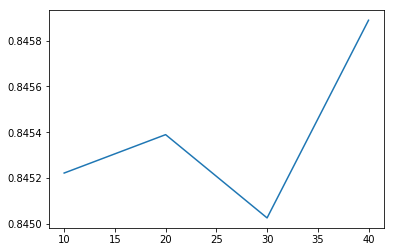

In [38]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = min_child_samples_s

plt.plot(x_axis, test_means)
#plt.errorbar(x_axis, -test_scores, yerr=test_stds ,label = ' Test')
#plt.errorbar(x_axis, -train_scores, yerr=train_stds,label =  +' Train')

plt.show()

In [39]:
test_means

array([ 0.84522116,  0.84538925,  0.84502473,  0.84588997])

#### 再次细调

In [41]:
params = {'boosting_type': 'goss',
          'objective': 'binary',
          'is_unbalance':True,
          'categorical_feature': [0,1,3,5,6,12,15,16,17,18,19,20],
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'num_leaves': 70,
          'max_depth': 6,
          'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

min_child_samples_s = range(40,60,10) 
tuned_parameters = dict( min_child_samples = min_child_samples_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="roc_auc", verbose=5, refit = False)
grid_search.fit(X_train , y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] min_child_samples=40 ............................................
[CV] min_child_samples=40 ............................................
[CV] min_child_samples=40 ............................................
[CV] min_child_samples=40 ............................................
[CV] ....... min_child_samples=40, score=0.862881495455, total=   0.8s
[CV] min_child_samples=40 ............................................
[CV] ....... min_child_samples=40, score=0.834211564386, total=   0.8s
[CV] ....... min_child_samples=40, score=0.835298576573, total=   1.0s
[CV] min_child_samples=50 ............................................
[CV] ....... min_child_samples=40, score=0.848797569978, total=   0.9s
[CV] min_child_samples=50 ............................................
[CV] min_child_samples=50 ............................................
[CV] ........ min_child_samples=40, score=0.84826059048, total=   0.8s
[CV] min_child_sa

[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:    2.7s remaining:    1.8s


[CV] ....... min_child_samples=50, score=0.845927519017, total=   0.5s
[CV] ........ min_child_samples=50, score=0.84658651844, total=   0.5s


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    3.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='goss',
        categorical_feature=[0, 1, 3, 5, 6, 12, 15, 16, 17, 18, 19, 20],
        colsample_bytree=0.7, is_unbalance=True, learning_rate=0.1,
        max_bin=255, max_depth=6, min_child_samples=10, min_child_weight=5,
        min_split_gain=0.0, n_estimators=38, n_jobs=4, num_leaves=70,
        objective='binary', random_state=0, reg_alpha=0.0, reg_lambda=0.0,
        silent=False, subsample=1.0, subsample_for_bin=50000,
        subsample_freq=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'min_child_samples': [40, 50]}, pre_dispatch='2*n_jobs',
       refit=False, return_train_score='warn', scoring='roc_auc',
       verbose=5)

In [42]:
# examine the best model
print(grid_search.best_score_)
print(grid_search.best_params_)

0.845889972267
{'min_child_samples': 40}


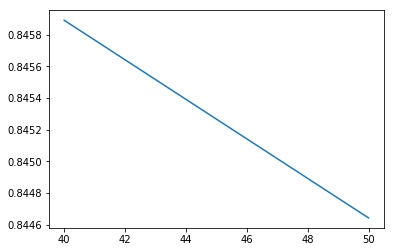

In [43]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = min_child_samples_s

plt.plot(x_axis, test_means)
#plt.errorbar(x_axis, -test_scores, yerr=test_stds ,label = ' Test')
#plt.errorbar(x_axis, -train_scores, yerr=train_stds,label =  +' Train')

plt.show()

#### min_child_samples=40

### 列采样参数 sub_feature/feature_fraction/colsample_bytree

In [44]:
params = {'boosting_type': 'goss',
          'objective': 'binary',
          'is_unbalance':True,
          'categorical_feature': [0,1,3,5,6,12,15,16,17,18,19,20],
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'num_leaves': 70,
          'max_depth': 6,
          'min_child_samples':40
          #'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

colsample_bytree_s = [i/10.0 for i in range(5,10)]
tuned_parameters = dict( colsample_bytree = colsample_bytree_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="roc_auc", verbose=5, refit = False)
grid_search.fit(X_train , y_train)
#grid_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] colsample_bytree=0.5 ............................................
[CV] colsample_bytree=0.5 ............................................
[CV] colsample_bytree=0.5 ............................................
[CV] colsample_bytree=0.5 ............................................
[CV] ....... colsample_bytree=0.5, score=0.861714971703, total=   0.9s
[CV] colsample_bytree=0.5 ............................................
[CV] ....... colsample_bytree=0.5, score=0.831381810407, total=   0.9s
[CV] ....... colsample_bytree=0.5, score=0.836188303893, total=   0.9s
[CV] colsample_bytree=0.6 ............................................
[CV] ....... colsample_bytree=0.5, score=0.850134164523, total=   0.9s
[CV] colsample_bytree=0.6 ............................................
[CV] colsample_bytree=0.6 ............................................
[CV] ....... colsample_bytree=0.5, score=0.851513115937, total=   0.9s
[CV] colsample_by

[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.9s


[CV] colsample_bytree=0.8 ............................................
[CV] ....... colsample_bytree=0.7, score=0.848797569978, total=   0.9s
[CV] ........ colsample_bytree=0.7, score=0.84826059048, total=   0.8s
[CV] colsample_bytree=0.8 ............................................
[CV] ....... colsample_bytree=0.7, score=0.834211564386, total=   1.0s
[CV] colsample_bytree=0.8 ............................................
[CV] colsample_bytree=0.8 ............................................
[CV] ....... colsample_bytree=0.8, score=0.860640370434, total=   1.1s
[CV] colsample_bytree=0.8 ............................................
[CV] ....... colsample_bytree=0.8, score=0.831301202037, total=   0.9s
[CV] ........ colsample_bytree=0.8, score=0.83630343566, total=   1.0s
[CV] colsample_bytree=0.9 ............................................
[CV] ....... colsample_bytree=0.8, score=0.843657351523, total=   0.9s
[CV] colsample_bytree=0.9 ............................................
[CV] c

[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    8.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='goss',
        categorical_feature=[0, 1, 3, 5, 6, 12, 15, 16, 17, 18, 19, 20],
        colsample_bytree=1.0, is_unbalance=True, learning_rate=0.1,
        max_bin=255, max_depth=6, min_child_samples=40, min_child_weight=5,
        min_split_gain=0.0, n_estimators=38, n_jobs=4, num_leaves=70,
        objective='binary', random_state=0, reg_alpha=0.0, reg_lambda=0.0,
        silent=False, subsample=1.0, subsample_for_bin=50000,
        subsample_freq=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='roc_auc', verbose=5)

In [45]:
# examine the best model
print(grid_search.best_score_)
print(grid_search.best_params_)

0.846186430268
{'colsample_bytree': 0.5}


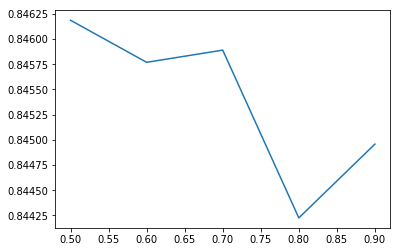

In [46]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = colsample_bytree_s

plt.plot(x_axis, test_means)
#plt.errorbar(x_axis, -test_scores[:,i], yerr=test_stds[:,i] ,label = str(max_depths[i]) +' Test')
#plt.errorbar(x_axis, -train_scores[:,i], yerr=train_stds[:,i] ,label = str(max_depths[i]) +' Train')

plt.show()

再调小一点

In [49]:
params = {'boosting_type': 'goss',
          'objective': 'binary',
          'is_unbalance':True,
          'categorical_feature': [0,1,3,5,6,12,15,16,17,18,19,20],
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'num_leaves': 70,
          'max_depth': 6,
          'min_child_samples':40
          #'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

colsample_bytree_s = [i/10.0 for i in range(3,6)]
tuned_parameters = dict( colsample_bytree = colsample_bytree_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="roc_auc", verbose=5, refit = False)
grid_search.fit(X_train , y_train)
#grid_search.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] colsample_bytree=0.3 ............................................
[CV] colsample_bytree=0.3 ............................................
[CV] colsample_bytree=0.3 ............................................
[CV] colsample_bytree=0.3 ............................................
[CV] ....... colsample_bytree=0.3, score=0.861468816098, total=   0.9s
[CV] colsample_bytree=0.3 ............................................
[CV] ....... colsample_bytree=0.3, score=0.833063511119, total=   0.9s
[CV] colsample_bytree=0.4 ............................................
[CV] ....... colsample_bytree=0.3, score=0.824688342886, total=   1.0s
[CV] colsample_bytree=0.4 ............................................
[CV] ......... colsample_bytree=0.3, score=0.8607024904, total=   1.0s
[CV] colsample_bytree=0.4 ............................................
[CV] ....... colsample_bytree=0.3, score=0.849136424933, total=   0.8s
[CV] colsample_by

[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed:    4.3s remaining:    1.1s


[CV] ....... colsample_bytree=0.5, score=0.831381810407, total=   0.9s
[CV] ....... colsample_bytree=0.5, score=0.850134164523, total=   0.8s
[CV] ....... colsample_bytree=0.5, score=0.851513115937, total=   0.8s


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    5.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='goss',
        categorical_feature=[0, 1, 3, 5, 6, 12, 15, 16, 17, 18, 19, 20],
        colsample_bytree=1.0, is_unbalance=True, learning_rate=0.1,
        max_bin=255, max_depth=6, min_child_samples=40, min_child_weight=5,
        min_split_gain=0.0, n_estimators=38, n_jobs=4, num_leaves=70,
        objective='binary', random_state=0, reg_alpha=0.0, reg_lambda=0.0,
        silent=False, subsample=1.0, subsample_for_bin=50000,
        subsample_freq=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'colsample_bytree': [0.3, 0.4, 0.5]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='roc_auc', verbose=5)

In [50]:
# examine the best model
print(grid_search.best_score_)
print(grid_search.best_params_)

0.849014497953
{'colsample_bytree': 0.4}


#### colsample_bytree=0.4

### 正则化参数lambda_l1(reg_alpha), lambda_l2(reg_lambda)感觉不用调了

### 减小学习率，调整n_estimators

In [52]:
params = {'boosting_type': 'goss',
          'objective': 'binary',
          'is_unbalance':True,
          'categorical_feature': [0,1,3,5,6,12,15,16,17,18,19,20],
          'n_jobs': 4,
          'learning_rate': 0.01,
          #'n_estimators':n_estimators_1,
          'num_leaves': 70,
          'max_depth': 6,
          'min_child_samples':40,
          'colsample_bytree': 0.4
         }
n_estimators_2 = get_n_estimators(params , X_train , y_train, early_stopping_rounds=50)

('best n_estimators:', 524)
('best cv score:', 0.84939448240588145)


### 用所有训练数据，采用最佳参数重新训练模型
由于样本数目增多，模型复杂度稍微扩大一点？
num_leaves增多5
#min_child_samples按样本比例增加到15

In [53]:
params = {'boosting_type': 'goss',
          'objective': 'binary',
          'is_unbalance':True,
          'categorical_feature': [0,1,3,5,6,12,15,16,17,18,19,20],
          'n_jobs': 4,
          'learning_rate': 0.01,
          #'n_estimators':n_estimators_1,
          'num_leaves': 75,
          'max_depth': 6,
          'min_child_samples':40,
          'colsample_bytree': 0.4
         }

lg = LGBMClassifier(silent=False,  **params)
lg.fit(X_train, y_train)

LGBMClassifier(boosting_type='goss',
        categorical_feature=[0, 1, 3, 5, 6, 12, 15, 16, 17, 18, 19, 20],
        colsample_bytree=0.4, is_unbalance=True, learning_rate=0.01,
        max_bin=255, max_depth=6, min_child_samples=40, min_child_weight=5,
        min_split_gain=0.0, n_estimators=10, n_jobs=4, num_leaves=75,
        objective='binary', random_state=0, reg_alpha=0.0, reg_lambda=0.0,
        silent=False, subsample=1.0, subsample_for_bin=50000,
        subsample_freq=1)

## 保存模型，用于后续测试

In [54]:
import cPickle

cPickle.dump(lg, open("HappyBank_LightGBM_.pkl", 'wb'))

### 特征重要性

In [55]:
df = pd.DataFrame({"columns":list(feat_names), "importance":list(lg.feature_importances_.T)})
df = df.sort_values(by=['importance'],ascending=False)

In [56]:
df

,columns,importance
13,Monthly_Income,82
0,City,79
9,Loan_Amount_Submitted,49
8,Loan_Amount_Applied,43
21,Age,40
7,Interest_Rate,39
2,EMI_Loan_Submitted,37
10,Loan_Tenure_Applied,37
14,Processing_Fee,29
20,Var5,28


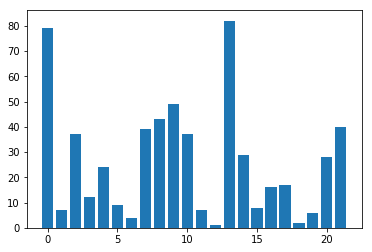

In [57]:
plt.bar(range(len(lg.feature_importances_)), lg.feature_importances_)
plt.show()